<a href="https://colab.research.google.com/github/bacdam91/mxnet-tutorial/blob/master/Training_the_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet

# Training the neural network

In this tutorial we will train the LeNet neural network with the FashionMNIST dataset.

### Fashion MNIST dataset

The Fashion MNIST dataset is a collection of $28 \times 28$ pixels greyscale images of clothing items. Each item is associated with a scalar label, a number, to identify the particular clothing item. Between this and the handwritten digits MNIST dataset, they are considered the "Hello World" tutorials of the Machine Learning world.

### Importing libraries

We will be importing some libraries for this tutorial. Some of the new ones include:
1. ```mxnet.init```: which will provide us with more weight initialisation methods
2. ```mxnet.gluon.data.vision.datasets```: which will help us load the Fashion MNIST dataset
3. ```mxnet.gluon.data.vision.transforms```: which will help us to transform the computer vision datasets
4. ```time```: which will help us with benchmarking
5. ```matplotlib.pyplot```: which will help us to output the dataset as drawings

In [0]:
from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
import time

### Downloading the dataset

Almost all Machine Learning libraries/frameworks provide a convenient method to download standard datasets, such the as Fashion MNIST. As such we will use MXNet's convenient method to download the dataset and inspect its first item.

Notice that the parameter ```train``` is set to ```True```. We are saying we would like to load the training set only. If set to ```False``` we will load the testing set. We will do that later.

__Note:__ As the Fashion MNIST is a standard dataset used for benchmarking, the dataset is of fixed sized and split for us. The reason for this is to prevent a more favourable randomisation and splitting. There are 60,000 examples in the training set and 10,000 examples in the test set.

In [3]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
("X shape: ", X.shape, "X dtype: ", X.dtype, "y: ", y)

('X shape: ', (28, 28, 1), 'X dtype: ', numpy.uint8, 'y: ', 2)

As we can see from the output, the ```X``` is a numpy array that is $28 \times 28 \times 1$. The dimensions stand for $height \times width \times channel$. The ```y``` is the label which tells us what the item is. In this case the first item is a pullover. All the items include:

0. t-shirt
1. trouser
2. pullover
3. dress
4. coat
5. sandal
6. shirt
7. sneaker
8. bag
9. ankle boot

As the dataset stores these labels as integers, we will need an array of these text labels so that we can read the the network's prediction and easy evaluate the accuracy of the neural network.

In [0]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

### Other datasets

Beside the handwritten digits and the fashion MNIST datasets, there are a few other datasets that are considered as standard datasets for newcomers to learn and researchers to run their experiments, another popular dataset is the Zachary's Karate Club dataset which is used mainly in Graph Neural Networks.

### Exploring the dataset with ```matplotlib```

Let's explore the dataset some more and see its visual representations with ```matplotlib```.  We won't go into too much of the code of ```matplotlib``` in this tutorial. However, there are some videos on the basic usage of ```matplotlib``` on this channel.

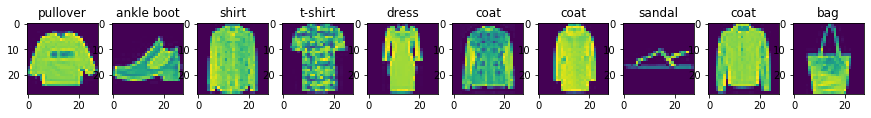

In [5]:
X, y = mnist_train[0:10]
# plot images
fig, ax = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f, xi, yi in zip(ax, X, y):
    # 3D->2D by removing the last channel dim
    f.imshow(xi.reshape((28,28)).asnumpy())
    f.set_title(text_labels[int(yi)])
plt.show()

### Transforming the data

In order to feed the data into a Gluon model, we need to transform the images into the (channel, height, width) format with floating point data type. We can do this with the ```transforms.ToTensor()``` method. In addition we will normalise all pixel values with ```transforms.Normalize()``` method. We can chain these two transforms together with ```transforms.Compose()``` which sequentially composes multiple transforms.

If you would like to understand these transforms in more details, you can check my channel for more tutorials.

In [0]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
mnist_train = mnist_train.transform_first(transformer)

### Creating the training data

In order to use the data for training, we need to get a (randomised) batch of examples. We can achieve this with the ```gluon.data.Dataloader()``` method. We will define an arbitary batch size of 256 examples. To allow randomisation, we will set shuffle to ```True``` and number of workers to 4, which will allow us to process data in parallel. This is often necessary especially for complex data transforms. 

In [0]:
batch_size = 256
train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

The return object from ```gluon.data.DataLoader()``` is an iterable object but __does__ not support indexing so to examine a batch, we will use the ```for``` loop follows by a ```break``` statement immediately.

We will also print out the number of batches generated with the method ```len()```.

In [8]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

print(len(train_data))

(256, 1, 28, 28) (256,)
235


Notice that there are 235 batches and we defined 256 examples in each batch. If we multiple the 2 figures we get, $235 \times 256 = 60,160$. As mentioned before, there are exactly 60,000 examples in the training set. If we remove the ```break``` statement and let the ```for``` loop print out the shape of all the mini-batches, we can see that the last batch has only 96 examples, which means $256 \times 234 + 96 = 60,000$.

### Preparing the testing data

Let's do the same method to get the test set ready for our neural network. 

Again, we can see that there are 40 batches: 256 examples in the first 39 batches and 16 examples in the last batch, $256 \times 39 + 16 = 10,000$.

In [9]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

for data, label in valid_data:
    print(data.shape, label.shape)
    break
print(len(valid_data))

(256, 1, 28, 28) (256,)
40


# Define the model

Let us reimplement the LeNet network introduced in the previous tutorial. The only difference here is that we will use the weight initialisation method ```Xavier``` instead, i.e., ```net.initialize(init=init.Xavier())```. This is a popular choice for deep convolutional neural networks.

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

### Inspecting parameters of the neural network

Once we have defined out neural network, we can have a look at the parameters, i.e., weights and biases, created with the method ```.collect_params()```.

In [11]:
net.collect_params()

sequential0_ (
  Parameter conv0_weight (shape=(6, 0, 5, 5), dtype=<class 'numpy.float32'>)
  Parameter conv0_bias (shape=(6,), dtype=<class 'numpy.float32'>)
  Parameter conv1_weight (shape=(16, 0, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter conv1_bias (shape=(16,), dtype=<class 'numpy.float32'>)
  Parameter dense0_weight (shape=(120, 0), dtype=float32)
  Parameter dense0_bias (shape=(120,), dtype=float32)
  Parameter dense1_weight (shape=(84, 0), dtype=float32)
  Parameter dense1_bias (shape=(84,), dtype=float32)
  Parameter dense2_weight (shape=(10, 0), dtype=float32)
  Parameter dense2_bias (shape=(10,), dtype=float32)
)

### Accessing parameters of the neural network

We can see that it outputs the layers defined in our neural network. These are indexed and each layer can be accessed like a dictionary by using the parameter's name as the key. However, initialisation does not actually happen until the first forward pass. As such if we try to access the ```shape``` properties of the layers not we will get a ```DeferredInitializationError``` thrown. We will have a look at those values a little later.

### Creating a loss function

Besides the neural network, we need to define the loss function and optimization method for training. We will use standard softmax cross entropy loss for classification problems. It first performs softmax on the output to obtain the predicted probability, and then compares the label with the cross entropy.

In [0]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Creating a Trainer
The optimization method we pick is the standard stochastic gradient descent (sgd) with constant learning rate of 0.1. We input these values into the ```gluon.Trainer()``` constructor, along with our list of parameters, i.e., ```net.collect_params()```. This will return a ```gluon.Trainer``` object which we will use for the training.

In [0]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

The trainer is created with all parameters (both weights and gradients) in net. Later on, we only need to call the ```.step()``` method to update its weights.

### Accuracy function

We will create an auxillary function to calculate the model accuracy. This function compares the predicted proobability with the labels, calculates the mean and return the value as a scalar.

In [0]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    score = (output.argmax(axis=1) == label.astype('float32')).mean().asscalar()
    return score

### Traing the network

Normally we would train the neural network for a few epochs and on the entire dataset. However, for demonstration purpose, we will train on 1 epoch and for 1 batch of 10 examples so that we can output the weights and gradients for explanation.

Let's reload the training and testing dataset with a batch size of 10. This is code is the same as what we have written previously.

In [0]:
batch_size = 10

mnist_train = datasets.FashionMNIST(train=True)
train_data = gluon.data.DataLoader(
    mnist_train.transform_first(transformer), batch_size=batch_size, shuffle=True, num_workers=4)

mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer), batch_size=batch_size, num_workers=4)

Let's run our neural network and output the results. We will go through and explain what is happening after.

In [16]:
for epoch in range(1):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        print("Shape of first convolutional layer:", net.collect_params()["conv0_weight"].data().shape)
        print("Weight values of first convolutional layer:", net.collect_params()["conv0_weight"].data())
        print("Grad before backward()", net.collect_params()["conv0_weight"].grad())
        loss.backward()
        print("Grad after backward(): ", net.collect_params()["conv0_weight"].grad())
        # update parameters
        trainer.step(batch_size)
        print("Weight values of first convolutional layer:", net.collect_params()["conv0_weight"].data())
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
        break
    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)
        break
    # print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
    #         epoch, train_loss/len(train_data), train_acc/len(train_data),
    #         valid_acc/len(valid_data), time.time()-tic))

    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/batch_size, train_acc/batch_size,
            valid_acc/batch_size, time.time()-tic))
    

Shape of first convolutional layer: (6, 1, 5, 5)
Weight values of first convolutional layer: 
[[[[ 0.01807702  0.03438295  0.07969065  0.12749125  0.03805615]
   [ 0.13255729  0.0166215   0.12859704 -0.02827276  0.04575911]
   [ 0.05402867 -0.0428167  -0.02311321 -0.07497861  0.14508452]
   [-0.16416161  0.17170732 -0.08419175 -0.04316488 -0.00827123]
   [ 0.10803397  0.11560483  0.0107006  -0.00741501  0.0251988 ]]]


 [[[-0.0397048   0.15761037  0.1244594  -0.15885738 -0.06021675]
   [-0.1528976   0.05487221 -0.17767657 -0.04879385  0.12317847]
   [ 0.16929738  0.10300924 -0.13318819  0.13702588  0.13705368]
   [ 0.17724578 -0.00977369  0.11078681  0.1114357  -0.01426527]
   [ 0.00758338  0.10388784  0.06624411 -0.14136368  0.08170648]]]


 [[[-0.03072909  0.18412147  0.08159234  0.16018812 -0.18512166]
   [-0.13771594 -0.07320179  0.18480872 -0.13081619 -0.09773365]
   [-0.15096845 -0.03829905 -0.11618664 -0.04150979 -0.05719319]
   [ 0.06286173 -0.0382299   0.16129233  0.01437493  

### Running the network

From the code we can see that we are running the neural network for 1 epoch. However, if you look inside the two ```for``` loops, the first ```for``` loop is for training and second ```for``` loop is for testing, on line 20 and 24, there are two ```break``` statements. These two ```break``` statements allow us to escape the loop and run only 1 batch of 10 examples. Needless to say our accuracy scores (0.01 for both training and test accuracy) won't be very good but that is not the purpose here.

On line 2 we initialise the training loss, train accuracy and test accuracy to 0 and we start the timer for each epoch on line 3.

#### Forward pass

From line 4 we start the training. The ```for``` loop loops through each batch of 10 examples. Within the ```autograd.record()``` scope we feed in the data, store the output in a variable, and calculate the loss with our loss function.

#### Layers initialization
The first time this runs, it initialises the weights and biases. Recalling what we talked about earlier regarding the ```.collect_params()``` method, we need to feed in a dataset before the network actually initialise we can access the weights and biases.

Let's have a look at the shape, the weight values and gradients of the first convolution layer. As we have not run the back propagation, we expect the gradient to 0s.

#### Back propagation
After running back propagation, i.e., ```loss.backward()```, we can see that the gradients have been calculated. 

#### Updating parameters
To update the parameters in each layers, we need to call the ```trainer.step(batch_size)```. We will output this and see that the weights have been updated and are not the same as previously.

#### Storing loss and accuracy
Line 18 and 19 are where we store the loss and accuracy score.

#### Testing the network
Line 22 is where we test the network. It is very similar to how we train the network.

#### Output the result
From line 25, the code is there for outputing the results. The commented out ```print()``` statement is what we would actually run when we train over the entire dataset and test over the entire test data.

However, since we only trained and tested over a batch, we will use the second ```print()``` statement.